In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [3]:
import os
os.path.exists('season_1/training_data/weather_data/weather_data_2016-01-01')

True

## 将数据整合到一个大的pandas.DataFrame 中
- 每张表包括 district_id, time_id, date, w 四个key coloumns。  
- 整合weather_dat 和 traffic_data
- 初步探索

### 整合weather_data

In [330]:
# 可以把所有的天气都合并起来
def weather_transfer(date):
    import pandas as pd
    wt = pd.read_csv('season_1/training_data/weather_data/weather_data_{}'.format(date.strftime("%Y-%m-%d")), sep='\t', header=None)
    wt.columns = ['time', 'weather','temp','pm25']
    wt.time = pd.to_datetime(wt.time, unit='s')
    wt["time_id"] = wt.time.apply(lambda x: x.hour*6 + int(x.minute/10) + 1)
    wts = wt.groupby('time_id', as_index=False).mean()
    wts['date'] = date
    wts['w'] = date.strftime("%w")
    return  wts

    

In [324]:
dt = pd.date_range('2016-01-01','2016-01-21',freq='D')

In [331]:
weather_data_list =[]
for date in dt:
    weather_data_list.append(weather_transfer(date))
wt_summary_df = pd.concat(weather_data_list)
    

In [332]:
wt_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2670 entries, 0 to 36
Data columns (total 6 columns):
time_id    2670 non-null int64
weather    2670 non-null float64
temp       2670 non-null float64
pm25       2670 non-null float64
date       2670 non-null datetime64[ns]
w          2670 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 146.0+ KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x141a7ef28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13a91f748>], dtype=object)

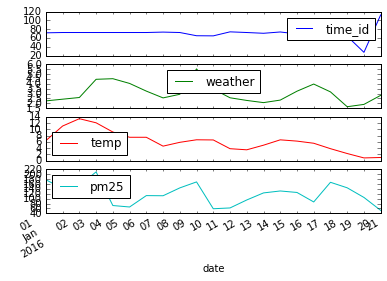

In [433]:
# 查看整体天气趋势
wt_summary_df.groupby('date').mean().plot(subplots=True)

### 整合 traffic_data

In [327]:
def level_process(colomns):
    if colomns.str[0].all() in ["{}".format(str(i)) for i in range(1,5)] and colomns.str[1].all() == ":":
        return colomns.str.split(":").apply(lambda  x: x[1])
    else:
        return colomns

# 特别注意读取数据时,地址可能不同。    
def traffic_data_transfer(date):
    """
    Use to transfer the raw traffic data to standard data with time_id, district_id, day columns 
    Input type: Datetime
    Output type: pd.DataFrame
    """
    
    # 读取数据,注意地址可能不同
    trf = pd.read_csv('season_1/training_data/traffic_data/traffic_data_{}'.format(date.strftime("%Y-%m-%d")), sep="\t", header=None)
    # 重命名coloumns
    trf.columns = ['district_hash','tj_level_1','tj_level_2','tj_level_3','tj_level_4','time']
    # 数据规整 tj_level data 
    trf = trf.apply(level_process)
    # 对时间进行格式化
    trf["time_id"] = pd.to_datetime(trf.time).apply(lambda x: x.hour*6 + int(x.minute/10)+1) 
    trf.drop("time", axis=1, inplace=True)
    # 读取 cluster_map 信息
    district_data = pd.read_csv('season_1/training_data/cluster_map/cluster_map', delimiter='\t',header=None)
    district_data.columns = ["district_hash","district_id"]
    # 合并信息
    trf = pd.merge(trf ,district_data,on="district_hash")
    trf.drop("district_hash", axis=1, inplace=True)
    # 转换所有值为数字
    trf = trf.apply(lambda x: pd.to_numeric(x))
    # 加入日期coloumns，作为唯一标记
    trf["date"] = date
    # 加入星期几 的 coloumns，作为类别标记
    trf["w"] = date.strftime("%w")

    return trf



#### 分布说明

In [215]:
### traffic_data 
# 获取值
trf_data = pd.read_csv('season_1/training_data/traffic_data/traffic_data_2016-01-01', sep="\t", header=None)
trf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9289 entries, 0 to 9288
Data columns (total 6 columns):
0    9289 non-null object
1    9289 non-null object
2    9289 non-null object
3    9289 non-null object
4    9289 non-null object
5    9289 non-null object
dtypes: object(6)
memory usage: 435.5+ KB


### 合标交通数据，以供分析
- 合标时间数据
- 合标地理数据
- 并入”gap“ 这个目标值

In [216]:
trf_data.columns = ['district_hash','tj_level_1','tj_level_2','tj_level_3','tj_level_4','time']
trf_data.head()
# 可以看到0是地区的hash 值， 

,district_hash,tj_level_1,tj_level_2,tj_level_3,tj_level_4,time
0,1ecbb52d73c522f184a6fc53128b1ea1,1:231,2:33,3:13,4:10,2016-01-01 23:30:22
1,1ecbb52d73c522f184a6fc53128b1ea1,1:305,2:69,3:13,4:16,2016-01-01 09:10:25
2,bf44d327f0232325c6d5280926d7b37d,1:579,2:87,3:28,4:16,2016-01-01 21:50:27
3,bf44d327f0232325c6d5280926d7b37d,1:242,2:28,3:10,4:9,2016-01-01 06:20:15
4,bf44d327f0232325c6d5280926d7b37d,1:471,2:35,3:15,4:17,2016-01-01 00:50:26


In [217]:
# 目的是批处理，希望通过 apply 将处理用到群体上，直接对于coloumns 使用 
# 使用 colomns.str[0].all() 如果有报错，说明有值错误。
def level_process(colomns):
    if colomns.str[0].all() in ["{}".format(str(i)) for i in range(1,5)] and colomns.str[1].all() == ":":
        return colomns.str.split(":").apply(lambda  x: x[1])
    else:
        return colomns
trf_data = trf_data.apply(level_process)
trf_data.head()

,district_hash,tj_level_1,tj_level_2,tj_level_3,tj_level_4,time
0,1ecbb52d73c522f184a6fc53128b1ea1,231,33,13,10,2016-01-01 23:30:22
1,1ecbb52d73c522f184a6fc53128b1ea1,305,69,13,16,2016-01-01 09:10:25
2,bf44d327f0232325c6d5280926d7b37d,579,87,28,16,2016-01-01 21:50:27
3,bf44d327f0232325c6d5280926d7b37d,242,28,10,9,2016-01-01 06:20:15
4,bf44d327f0232325c6d5280926d7b37d,471,35,15,17,2016-01-01 00:50:26


In [224]:
# 处理时间数据
trf_data["time_id"] = pd.to_datetime(trf_data.time).apply(lambda x: x.hour*6 + int(x.minute/10)+1) 
trf_data.drop("time", axis=1, inplace=True)

In [220]:
# 使用 cluster data 对 trf_data 的地理位置合标操作
district_data = pd.read_csv('season_1/training_data/cluster_map/cluster_map', delimiter='\t',header=None)
district_data.columns = ["district_hash","district_id"]

In [226]:
# 合并信息
trf_data = pd.merge(trf_data ,district_data,on="district_hash")
trf_data.drop("district_hash", axis=1, inplace=True)

In [263]:
# 转换所有值为数字
trf_data = trf_data.apply(lambda x: pd.to_numeric(x))

In [281]:
#看看 time_id 和 district_data 
trf_data = trf_data.groupby(["time_id", "district_id"], as_index=False).mean().head()

--------

#### 合并获得最终合并表summary

In [328]:
dt = pd.date_range('2016-01-01','2016-01-21')
traffic_data_list = []
for date in dt:
    traffic_data_list.append(traffic_data_transfer(date))
trf_summary_df = pd.concat(traffic_data_list)
    

In [311]:
# 获得 星期几的labels 要好很多 
dt[0].strftime("%w")

'5'

In [346]:
## 把 weather 信息合并
summary_df = pd.merge(trf_summary_df, wt_summary_df, on=["date","w","time_id"])

In [392]:
summary_df.describe()

,tj_level_1,tj_level_2,tj_level_3,tj_level_4,time_id,district_id,weather,temp,pm25
count,172308.000000,172308.000000,172308.000000,172308.000000,172308.000000,172308.000000,172308.000000,172308.000000,172308.000000
mean,598.056173,126.300445,37.831006,25.629994,71.271229,33.199074,3.099290,6.650637,122.050491
std,701.701138,213.717970,66.374053,41.295776,41.331211,19.025296,1.617086,3.618044,51.114466
min,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,26.000000
25%,145.000000,16.000000,4.000000,3.000000,35.000000,17.000000,2.000000,4.000000,86.000000
50%,319.000000,48.000000,14.000000,10.000000,71.000000,33.000000,2.500000,7.000000,118.000000
75%,774.000000,142.000000,41.000000,30.000000,107.000000,49.000000,4.000000,8.000000,159.000000
max,4223.000000,2084.000000,842.000000,449.000000,144.000000,66.000000,9.000000,19.000000,276.000000


In [349]:
# 最后加入 gap target
order_data_list = []
for date in dt:
    
    order = pd.read_csv('./order_data_{}_gap.csv'.format(date.strftime("%Y-%m-%d")))
    order["date"] = date
    order["w"] = date.strftime("%w")
    order_data_list.append(order)

order_summary_df = pd.concat(order_data_list)

In [357]:
# 最后的合并
summary = pd.merge(summary_df, order_summary_df, on=["district_id","time_id","w","date"], how="outer")

In [390]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172308 entries, 0 to 172307
Data columns (total 12 columns):
tj_level_1     172308 non-null float64
tj_level_2     172308 non-null float64
tj_level_3     172308 non-null float64
tj_level_4     172308 non-null float64
time_id        172308 non-null float64
district_id    172308 non-null float64
date           172308 non-null datetime64[ns]
w              172308 non-null object
weather        172308 non-null float64
temp           172308 non-null float64
pm25           172308 non-null float64
gap            172308 non-null float64
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 17.1+ MB


In [369]:
# 把gap 是NaN的填充为 0 ，表示没人下单， 这是合乎情理的
summary.gap.fillna(0, inplace=True)
summary.dropna(inplace=True)

In [410]:
# 可以看到，合并但保留了所有的信息
summary.head()

,tj_level_1,tj_level_2,tj_level_3,tj_level_4,time_id,district_id,date,w,weather,temp,pm25,gap
0,231.0,33.0,13.0,10.0,142.0,66.0,2016-01-01,5,2.0,8.0,126.0,0.0
1,449.0,46.0,19.0,11.0,142.0,64.0,2016-01-01,5,2.0,8.0,126.0,1.0
2,788.0,95.0,12.0,21.0,142.0,2.0,2016-01-01,5,2.0,8.0,126.0,0.0
3,7.0,0.0,0.0,0.0,142.0,15.0,2016-01-01,5,2.0,8.0,126.0,0.0
4,105.0,13.0,2.0,0.0,142.0,5.0,2016-01-01,5,2.0,8.0,126.0,0.0


In [412]:
pd.to_datetime("2016-01-01")

Timestamp('2016-01-01 00:00:00')

In [415]:
# 由于 2016-01-01 比较特别，是假日，很可能有特别的分布特征，因此处理的时候要小心~
# 使用如下形式 可以排除 这一天：
summary[summary.date != pd.to_datetime("2016-01-01")].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163149 entries, 9159 to 172307
Data columns (total 12 columns):
tj_level_1     163149 non-null float64
tj_level_2     163149 non-null float64
tj_level_3     163149 non-null float64
tj_level_4     163149 non-null float64
time_id        163149 non-null float64
district_id    163149 non-null float64
date           163149 non-null datetime64[ns]
w              163149 non-null object
weather        163149 non-null float64
temp           163149 non-null float64
pm25           163149 non-null float64
gap            163149 non-null float64
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 16.2+ MB


### 对整体特征的探索，根据training_data
- 发现gap全部为零的数据比例为 0.287
- 时间上有明显的高低峰
- 周末和工作日区别明显，工作日周四、周五和周一周二周三也有较大的区别 

In [423]:
summary_analysis = summary[summary.date != pd.to_datetime("2016-01-01")].groupby(["time_id", "district_id", "w"]).mean()

In [424]:
summary_analysis["std"] = summary[summary.date != pd.to_datetime("2016-01-01")].groupby(["time_id", "district_id", "w"]).std()["gap"]

In [425]:
# 发现全部为零的数据还是很多的。 有 18700 / 65000 = 0.287 。也就是在1/4 至 1/3 之间的比例。
# 这些数据可以安全的预测为零。印象这些的和地域信息居住信息有关，信息是不完备的。
summary_analysis[summary_analysis.gap == 0].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19992 entries, (2.0, 2.0, 1) to (144.0, 66.0, 5)
Data columns (total 9 columns):
tj_level_1    19992 non-null float64
tj_level_2    19992 non-null float64
tj_level_3    19992 non-null float64
tj_level_4    19992 non-null float64
weather       19992 non-null float64
temp          19992 non-null float64
pm25          19992 non-null float64
gap           19992 non-null float64
std           19017 non-null float64
dtypes: float64(9)
memory usage: 1.5+ MB


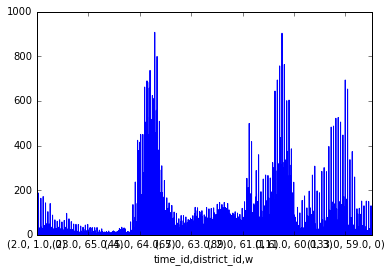

In [420]:
summary_analysis.gap.plot()
#从时间轴作为主线来看，有上班高峰，下班高峰，和晚上高峰的三个时间聚集点

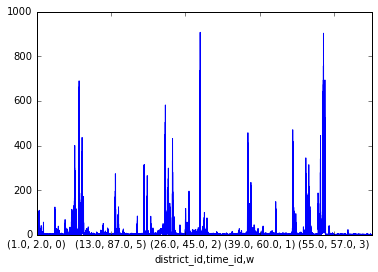

In [426]:
summary_analysis_district_first = summary[summary.date != pd.to_datetime("2016-01-01")].groupby(["district_id", "time_id", "w"]).mean()
# summary_analysis_district_first[summary_analysis_district_first.gap > 0].gap.plot()
# 将地区作为主线，就会发现，相比于 时间，地区的影响并不很连续。

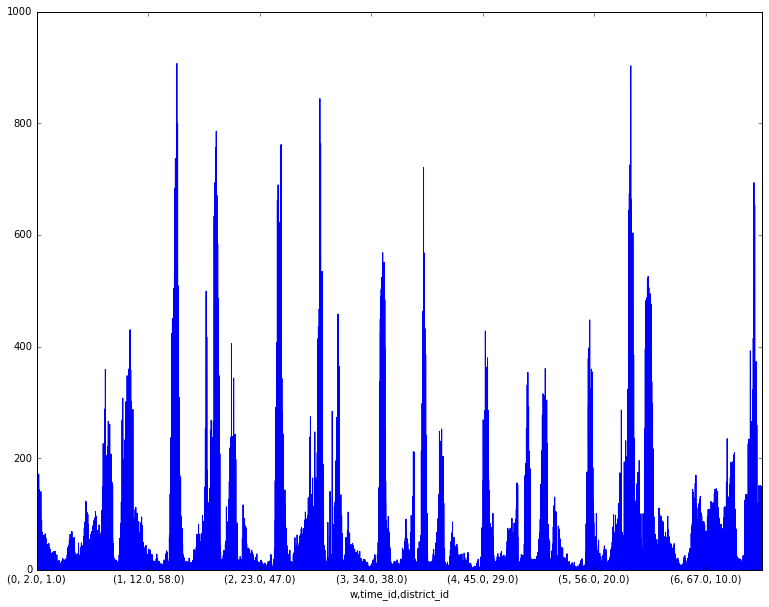

In [431]:
summary_analysis_week = summary[summary.date != pd.to_datetime("2016-01-01")].groupby(["w","time_id", "district_id"]).mean()
summary_analysis_week.gap.plot(figsize=(13,10))
# 将星期作为主线，在工作日以时间作为主线的四个峰更明晰。
# 工作日(”w” in [1-5]) 中 的 格局 和 周末[6-7] 不同, 四个峰的高低可以明晰的看出。
# 和我的预期有些不一致的是工作日可能出现局部没有车的情况大于周末。
# 图中根据每一个星期中七天的特点会发现 周一和周二是很相似的。

### 验证validation：
- cross-test validation K-folds 如何进行我暂时还有些模糊


### 归一化处理

In [511]:
def normalization(data):
    data_min = np.min(data)
    data_range = np.max(data) - np.min(data)
    return data.apply(lambda x: (x-data_min)/data_range)

summary_normalized = summary.copy()
# tj_level 
for i in range(1,5):
    summary_normalized["tj_level_{}".format(i)] =  normalization(
        summary_normalized["tj_level_{}".format(i)]
    )

# temp 
for item in ["temp","pm25"]:
    summary_normalized[item] = normalization(
        summary_normalized[item]
        )
    
summary_normalized.head()

,tj_level_1,tj_level_2,tj_level_3,tj_level_4,time_id,district_id,date,w,weather,temp,pm25,gap
0,0.054700,0.015835,0.015439,0.022272,142.0,66.0,2016-01-01,5,2.0,0.421053,0.4,0.0
1,0.106323,0.022073,0.022565,0.024499,142.0,64.0,2016-01-01,5,2.0,0.421053,0.4,1.0
2,0.186597,0.045585,0.014252,0.046771,142.0,2.0,2016-01-01,5,2.0,0.421053,0.4,0.0
3,0.001658,0.000000,0.000000,0.000000,142.0,15.0,2016-01-01,5,2.0,0.421053,0.4,0.0
4,0.024864,0.006238,0.002375,0.000000,142.0,5.0,2016-01-01,5,2.0,0.421053,0.4,0.0


 
### 将 target: "gap"转为 类别变量 

In [465]:
# 会发现 有接近50% 的 gap 数据都为 0 ，
summary_normalized[summary_normalized.gap == 0].shape[0] /summary_normalized.shape[0] 

0.49170090767695057

In [479]:
# 有25% 的比例 为 1或2 
summary_normalized[summary_normalized.gap == 1].shape[0] /summary_normalized.shape[0]

0.15779882535924042

In [469]:
summary_normalized[summary_normalized.gap == 2].shape[0] /summary_normalized.shape[0] 

0.0857011862478817

In [488]:
# 把 gap 变为分类变量
# 去除 gap = 0 的情况
# 这样可以做一个分类，[0,1,2,3] 分别对应 gap 为 0，1-2，3-5，大于5 的四种情况。
qcut_result = pd.qcut(summary_normalized[summary_normalized.gap > 0].gap, 3)

In [512]:
# 转类别变量 函数 gap_map
gap_map_dict = { 0:[0], 1:[1,2], 2:[3,4,5], 3:range(5,10000) }
def gap_map(x):
    gap_map_dict = { 0:[0], 1:[1,2], 2:[3,4,5], 3:range(5,10000) }
    map_list = list(gap_map_dict.items())
    for i in range(len(map_list)):
        if x in map_list[i][1]:
            return map_list[i][0]
    

In [513]:
# 离散类别化处理
# 保证如果多执行一次，也不会出错
if np.max(summary_normalized.gap)> 3: 
    summary_normalized.gap = summary_normalized.gap.apply(gap_map)

In [514]:
summary_normalized.gap.describe()

count    172308.000000
mean          0.922993
std           1.095564
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: gap, dtype: float64

In [437]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier()
